---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

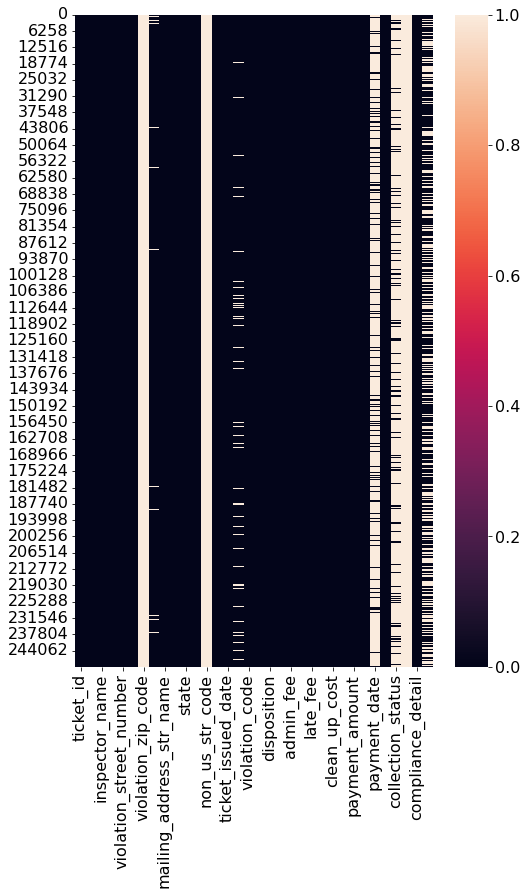

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
train=pd.read_csv('train.csv',  encoding= 'ISO-8859-1',low_memory=False)
#pd.set_option('display.max_columns', 34)
fig, ax = plt.subplots(figsize = (8, 12))
ax = sns.heatmap(train.isnull())

In [43]:
#eliminación columnas nulas,duplicados y nan
train.drop(['violation_zip_code','non_us_str_code','payment_date','collection_status','grafitti_status'],axis=1,inplace=True)
print(f' Hay {train.duplicated().sum()} duplicados en el dataset')
train.dropna(inplace=True)
#variables string
train.drop(['agency_name','inspector_name','violator_name','violation_street_name','mailing_address_str_number','mailing_address_str_name','city','state','zip_code','country','ticket_issued_date','hearing_date','violation_code','violation_description','disposition','discount_amount','payment_amount','balance_due','clean_up_cost','payment_status','compliance_detail'],axis=1,inplace=True)

 Hay 0 duplicados en el dataset


In [44]:
test=pd.read_csv('test.csv', encoding= 'ISO-8859-1',low_memory=False)
#pd.set_option('display.max_columns', 34)
#eliminación columnas nulas,duplicados y nan
test.drop(['violation_zip_code','non_us_str_code','grafitti_status'],axis=1,inplace=True)
print(f' Hay {train.duplicated().sum()} duplicados en el dataset')
test.dropna(inplace=True)
#variables string
test.drop(['agency_name','inspector_name','violator_name','violation_street_name','mailing_address_str_number','mailing_address_str_name','city','state','zip_code','country','ticket_issued_date','hearing_date','violation_code','violation_description','disposition','discount_amount','clean_up_cost'],axis=1,inplace=True)

 Hay 0 duplicados en el dataset


Modelo

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [46]:
#separo en datos y etiqueta y escalo
X=train.iloc[:,:-1]
y=train.compliance
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(test)
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, random_state = 0)

In [47]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 0.01,random_state = 0,
                    batch_size = 100, max_iter = 1000, solver='adam')
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

0.9314558934683097
0.9328662420382166


In [48]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score, roc_auc_score, roc_curve, f1_score

train_proba = clf.predict_proba(X_train)[:, 1]
test_proba = clf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_proba)} y Test ROC AUC  Score: {roc_auc_score(y_test, test_proba)}')

Train ROC AUC Score: 0.769109848428196 y Test ROC AUC  Score: 0.7644937896015246


In [49]:
y_pred_clf = clf.predict(X_test)
y_train_pred_clf = clf.predict(X_train)

In [50]:
from sklearn.ensemble import RandomForestClassifier
X=train.iloc[:,:-1]
y=train.compliance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
rf = RandomForestClassifier(max_depth=3 ,max_features = 2)
rf.fit(X_train, y_train)

print('Accuracy of RF classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.93
Accuracy of RF classifier on test set: 0.93


In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score, roc_auc_score, roc_curve, f1_score

train_rf_proba = rf.predict_proba(X_train)[:, 1]
test_rf_proba = rf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_rf_proba)} y Test ROC AUC  Score: {roc_auc_score(y_test, test_rf_proba)}')

Train ROC AUC Score: 0.7736685673253194 y Test ROC AUC  Score: 0.7695179399910229


In [52]:
y_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

ROC MLPClassifier


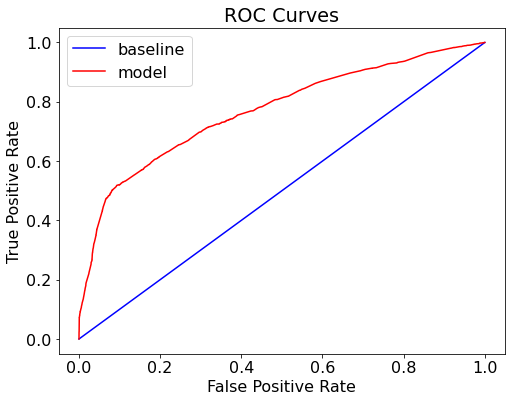

ROC RandomForest


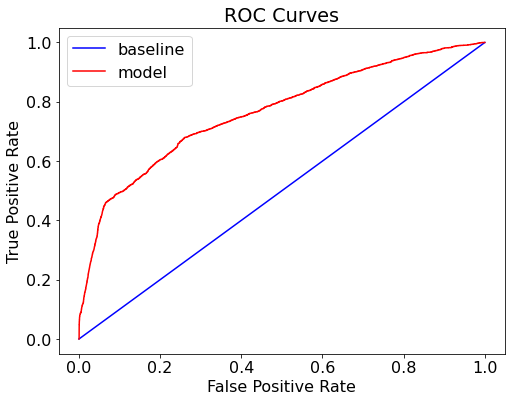

In [53]:
def evaluate_model(y_pred, test_proba ,train_predictions, train_proba):

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, test_proba)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();
print('ROC MLPClassifier')
evaluate_model(y_pred,test_rf_proba,y_train_pred,train_rf_proba)
print('ROC RandomForest')
evaluate_model(y_pred_clf,test_proba,y_train_pred_clf,train_proba)

In [54]:
test_proba = rf.predict_proba(test)[:,1]
test['compliance'] = test_proba
test.set_index('ticket_id', inplace=True)
test.compliance

ticket_id
284932    0.077560
285362    0.044222
285361    0.077630
285338    0.082447
285346    0.082447
            ...   
376496    0.044330
376497    0.044330
376499    0.077560
376500    0.077560
369851    0.303318
Name: compliance, Length: 57495, dtype: float64